In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
import tensorflow as tf

tf.random.set_seed(7879)

Init Plugin
Init Graph Optimizer
Init Kernel


활성화 함수의 종류
1. 이진 계단 함수(Binary step function
2. 선형 활성화 함수(Linear activation function
3. 비선형 활성화 함수(Non-linear activation function)

## 이진 계단 함수(Binary step function)
이 함수로 들어온 입력이 특정 임계점을 넘으면 1(혹은 True)를 출력하고 그렇지 않을 때는 0을 출력

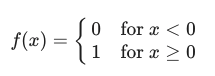

In [2]:
def binary_step(x, threshold=0): 
# threshold가 있는 함수를 쓰면 꼭 defualt 값을 설정해주세요
    return 0 if x<threshold else 1

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_and_visulize(image_url, function, derivative=False):
    X = [-10 + x/100 for x in range(2000)]
    y = [function(y) for y in X]
    
    plt.figure(figsize=(12,12))
    
    # 함수 그래프
    plt.subplot(3,2,1)
    plt.title('function')
    plt.plot(X,y)
    
    # 함수의 미분 그래프
    plt.subplot(3,2,2)
    plt.title('derivative')
    if derivative:
        dev_y = [derivative(y) for y in X]
        plt.plot(X,dev_y)
    
    # 무작위 샘플들 분포
    samples = np.random.rand(1000)
    samples -= np.mean(samples)
    plt.subplot(3,2,3)
    plt.title('samples')
    plt.hist(samples,100)
    
    # 활성화 함수를 통과한 샘플들 분포
    act_values = [function(y) for y in samples]
    plt.subplot(3,2,4)
    plt.title('activation values')
    plt.hist(act_values,100)
    
    # 원본 이미지
    image = np.array(Image.open(image_url), dtype=np.float64)[:,:,0]/255. # 구분을 위해 gray-scale해서 확인
    image -= np.median(image)
    plt.subplot(3,2,5)
    plt.title('origin image')
    plt.imshow(image, cmap='gray')
    
    # 활성화 함수를 통과한 이미지
    activation_image = np.zeros(image.shape)
    h, w = image.shape
    for i in range(w):
        for j in range(h):
            activation_image[j][i] += function(image[j][i])
    plt.subplot(3,2,6)
    plt.title('activation results')
    plt.imshow(activation_image, cmap='gray')
    
    return plt

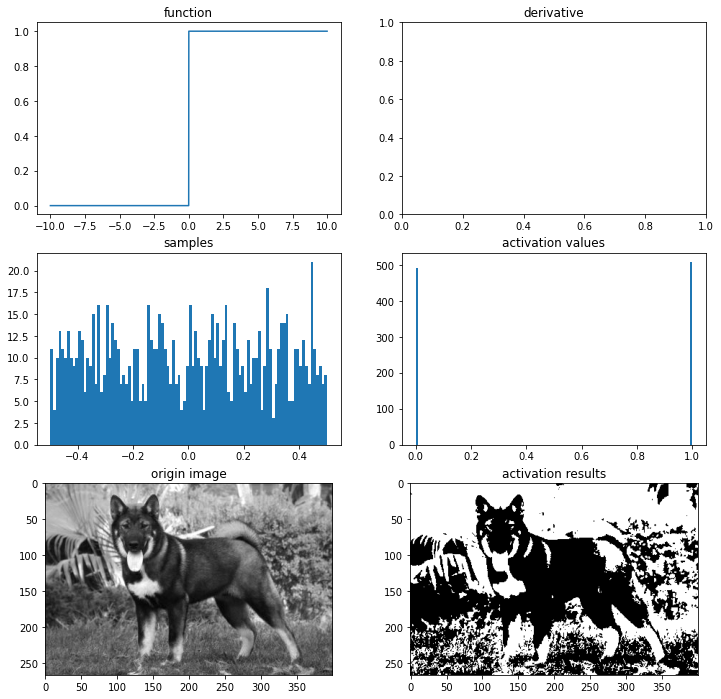

In [4]:
import os
img_path = os.getenv('HOME')+'/desktop/data/activation/jindo_dog.jpg'
ax = plot_and_visulize(img_path, binary_step)
ax.show()

이진 계단 함수는 단층 퍼셉트론(single layer perceptrons)라는 초기의 신경망에서 자주 사용되었습니다.

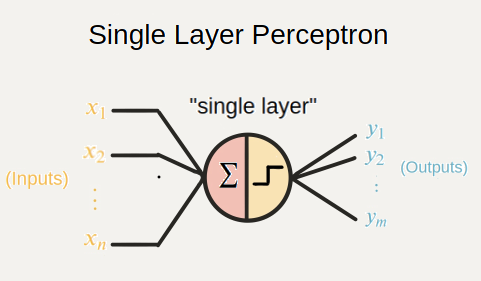

In [5]:
# 퍼셉트론
class Perceptron(object):
    def __init__(self, input_size, activation_ftn, threshold=0, learning_rate=0.01):
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn(1)
        self.activation_ftn = np.vectorize(activation_ftn)
        self.learning_rate = learning_rate
        self.threshold = threshold

    def train(self, training_inputs, labels, epochs=100, verbose=1):
        '''
        verbose : 0-매 에포크 결과 출력, 
                  1-마지막 결과만 출력 
        '''
        for epoch in range(epochs):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.__call__(inputs)
                self.weights += self.learning_rate * (label - prediction) * inputs
                self.bias += self.learning_rate * (label - prediction)
            if verbose == 1:
                pred = self.__call__(training_inputs)
                accuracy = np.sum(pred==labels)/len(pred)
                print(f'{epoch}th epoch, accuracy : {accuracy}')
        if verbose == 0:
            pred = self.__call__(training_inputs)
            accuracy = np.sum(pred==labels)/len(pred)
            print(f'{epoch}th epoch, accuracy : {accuracy}')
    
    def get_weights(self):
        return self.weights, self.bias
                
    def __call__(self, inputs):
        summation = np.dot(inputs, self.weights) + self.bias
        return self.activation_ftn(summation, self.threshold)

이러한 신경망은 선형적으로 구분 가능한(linearly separable) 문제(예를 들면, AND gate 또는 OR gate)를 구현할 수 있습니다.

In [6]:
def scatter_plot(plt, X, y, threshold = 0, three_d=False):
    ax = plt
    if not three_d:
        area1 = np.ma.masked_where(y <= threshold, y)
        area2 = np.ma.masked_where(y > threshold, y+1)
        ax.scatter(X[:,0], X[:,1], s = area1*10, label='True')
        ax.scatter(X[:,0], X[:,1], s = area2*10, label='False')
        ax.legend()
    else:
        area1 = np.ma.masked_where(y <= threshold, y)
        area2 = np.ma.masked_where(y > threshold, y+1)
        ax.scatter(X[:,0], X[:,1], y-threshold, s = area1, label='True')
        ax.scatter(X[:,0], X[:,1], y-threshold, s = area2, label='False')
        ax.scatter(X[:,0], X[:,1], 0, s = 0.05, label='zero', c='gray')
        ax.legend()
    return ax

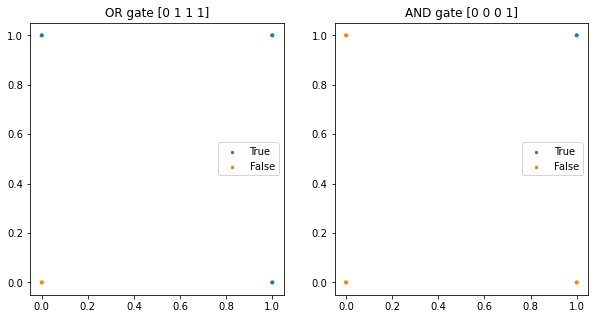

In [7]:
# AND gate, OR gate
X = np.array([[0,0], [1,0], [0,1], [1,1]])

plt.figure(figsize=(10,5))
# OR gate
or_y = np.array([x1 | x2 for x1,x2 in X])
ax1 = plt.subplot(1,2,1)
ax1.set_title('OR gate ' + str(or_y))
ax1 = scatter_plot(ax1, X, or_y)

# AND gate
and_y = np.array([x1 & x2 for x1,x2 in X])
ax2 = plt.subplot(1,2,2)
ax2.set_title('AND gate ' + str(and_y))
ax2 = scatter_plot(ax2, X, and_y)

plt.show()

이진 계단 함수의 임계점이 0이라고 하면 위의 gate들은 다음과 같이 단층 퍼셉트론으로 구현할 수 있습니다.  
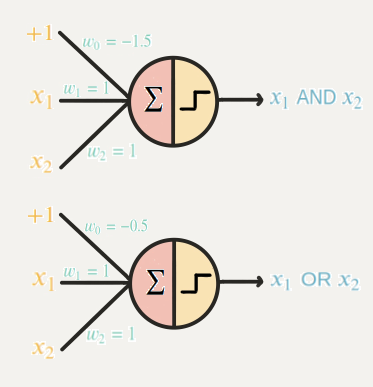

In [8]:
# OR gate
or_p = Perceptron(input_size=2, activation_ftn=binary_step)
or_p.train(X, or_y, epochs=1000, verbose=0)
print(or_p.get_weights()) # 가중치와 편향값은 훈련마다 달라질 수 있습니다.

# AND gate
and_p = Perceptron(input_size=2, activation_ftn=binary_step)
and_p.train(X, and_y, epochs=1000, verbose=0)
print(and_p.get_weights()) # 가중치와 편향값은 훈련마다 달라질 수 있습니다.

999th epoch, accuracy : 1.0
(array([2.00562077, 0.13132858]), array([-0.12665007]))
999th epoch, accuracy : 1.0
(array([0.0105891 , 0.01915001]), array([-0.02232467]))


단층 퍼셉트론 모델의 추론 결과를 그래프로 그려 보겠습니다. 

위에서 그려보았던 그래프가 4개의 점으로 표시된 것에 비해, 아래 그려질 그래프는 x, y축를 100등분한 결과를 모델에 대입하여 True와 False의 경계선이 선형적으로 드러나도록 그려질 것입니다. 

위에서 언급한 것처럼 퍼셉트론이 **하나의 선으로 구분할 수 있는 문제를 풀 수 있다** 는 것을 시각적으로 확인하기 위해서입니다.

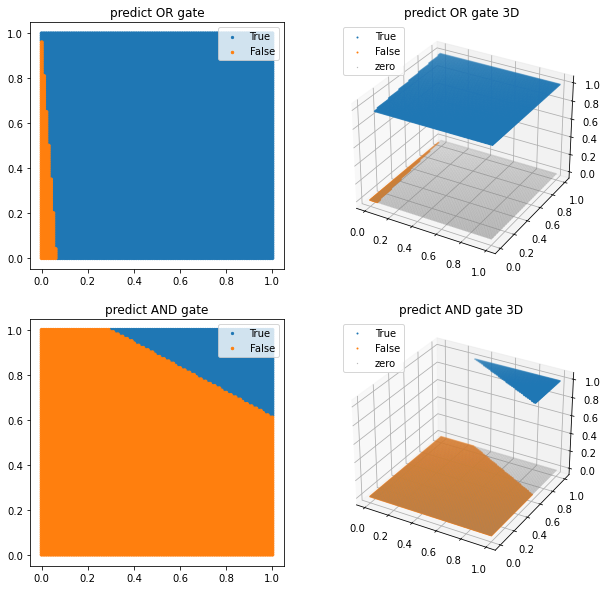

In [9]:
from itertools import product

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_or_y = or_p(test_X)
pred_and_y = and_p(test_X)

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ax1.set_title('predict OR gate')
ax1 = scatter_plot(ax1, test_X, pred_or_y)

ax2 = plt.subplot(2,2,2, projection='3d')
ax2.set_title('predict OR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_or_y, three_d=True)

ax3 = plt.subplot(2,2,3)
ax3.set_title('predict AND gate')
ax3 = scatter_plot(ax3, test_X, pred_and_y)

ax4 = plt.subplot(2,2,4, projection='3d')
ax4.set_title('predict AND gate 3D')
ax4 = scatter_plot(ax4, test_X, pred_and_y, three_d=True)

plt.show()

이 그래프의 모양은 단층 퍼셉트론을 훈련(train)할 때마다 다르게 그려질 것입니다. 

OR gate와 AND gate의 accuracy를 1.0으로 만드는 퍼셉트론의 최적 가중치 값은 하나로 정해져 있지 않으므로, 따라서 이 가중치에 의해 결정되는 그래프의 모양도 계속 달라집니다. 

그러나 중요한 것은 퍼셉트론의 가중치가 결정짓는 경계선을 기준으로 [[0,0], [1,0], [0,1], [1,1]] 이상 4개의 점에서의 OR gate, AND gate의 진릿값이 정확한가 하는 것입니다.



### 이진 계단 함수의 한계 1
단층 퍼셉트론은 XOR gate를 구현할 수 없습니다.  
XOR gate의 진릿값 그래프를 하나의 선으로 구분을 할 수 없기 때문입니다.


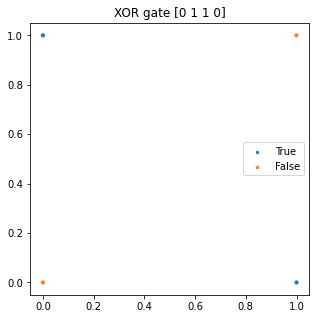

In [10]:
# XOR gate
threshold = 0
X = np.array([[0,0], [1,0], [0,1], [1,1]])

plt.figure(figsize=(5,5))
xor_y = np.array([x1 ^ x2 for x1,x2 in X])
plt.title('XOR gate '+ str(xor_y))
plt = scatter_plot(plt, X, xor_y)
plt.show()

999th epoch, accuracy : 0.25
(array([-0.02638034, -0.02167813]), array([0.02013661]))


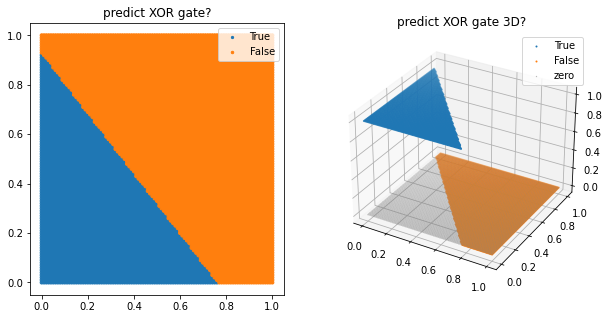

In [11]:
# XOR gate가 풀릴까?
xor_p = Perceptron(input_size=2, activation_ftn=binary_step, threshold=threshold)
xor_p.train(X, xor_y, epochs=1000, verbose=0)
print(xor_p.get_weights())

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_xor_y = xor_p(test_X)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('predict XOR gate?')
ax1 = scatter_plot(ax1, test_X, pred_xor_y)

ax2 = plt.subplot(1,2,2, projection='3d')
ax2.set_title('predict XOR gate 3D?')
ax2 = scatter_plot(ax2, test_X, pred_xor_y, three_d=True)

plt.show()

이를 해결할수 있는 방법은 여러 층을 쌓은 모델인 **다층 퍼셉트론(multi-layer perceptron, MLP)**입니다.  
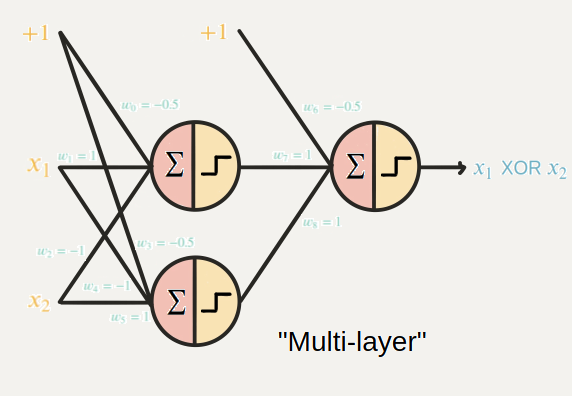

### 이진 계단 함수의 한계 2
**역전파 알고리즘(backpropagation algorithm)을 사용하지 못하는 것**입니다.  
이진 계단 함수는 0에서는 미분이 안 될 뿐더러 0인 부분을 제외하고 미분을 한다고 해도 미분값이 전부 0이 나옵니다. 때문에 역전파에서 가중치들이 업데이트되지 않습니다.  

https://en.wikipedia.org/wiki/Perceptron

또한 다중 출력은 할 수 없다는 단점이 있습니다.  
이진 계단 함수는 출력을 1 또는 0으로 밖에 주지 못하기 때문에 다양한 클래스를 구분해야 하는 문제는 해결할 수 없습니다.

## 선형 활성화 함수(Linear Activation Function)
선형 활성화 함수는 다중 출력이 가능해서 이진 분류는 물론이곡 간단한 다중 분류 문제까지도 해결할 수 있습니다. 

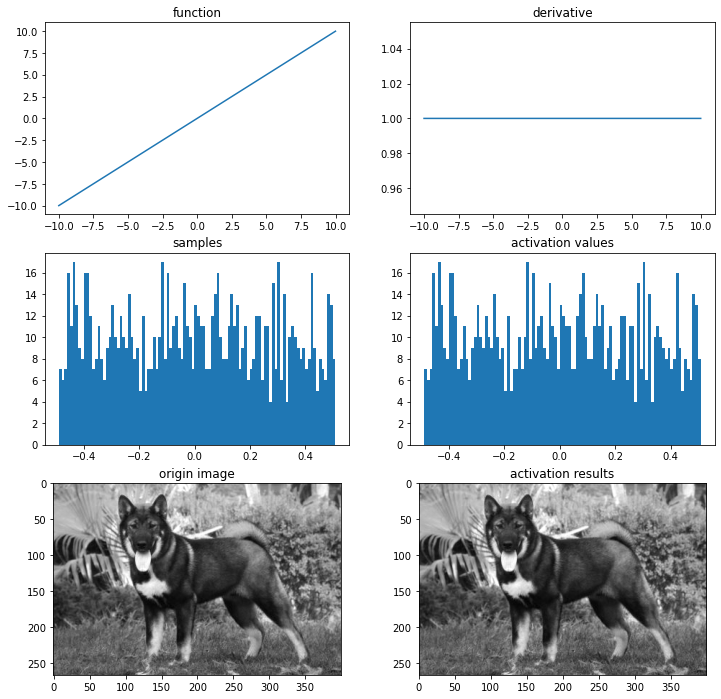

In [12]:
import os
img_path = os.getenv('HOME')+'/desktop/data/activation/jindo_dog.jpg'

# 선형 함수
def linear(x):
    return x

def dev_linear(x):
    return 1

# 시각화
ax = plot_and_visulize(img_path, linear, dev_linear)
ax.show()

선형 활성화 함수의 치역은 실수 전체입니다.

선형 활성화 함수를 사용한 모델은 그 이름에 걸맞게 선형적으로 구분 가능한 문제를 해결할 수 있습니다. 조금 전에 보았던 AND gate와 OR gate를 가져와 보겠습니다.



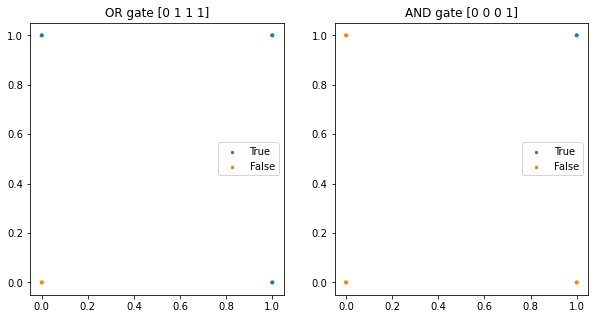

In [13]:
# AND gate, OR gate
threshold = 0
X = np.array([[0,0], [1,0], [0,1], [1,1]])

plt.figure(figsize=(10,5))
# OR gate
or_y = np.array([x1 | x2 for x1,x2 in X])
ax1 = plt.subplot(1,2,1)
ax1.set_title('OR gate ' + str(or_y))
ax1 = scatter_plot(ax1, X, or_y)

# AND gate
and_y = np.array([x1 & x2 for x1,x2 in X])
ax2 = plt.subplot(1,2,2)
ax2.set_title('AND gate ' + str(and_y))
ax2 = scatter_plot(ax2, X, and_y)

plt.show()

선형 활성화 함수를 사용한 단층 퍼셉트론을 이용해 해당 gate를 다음과 같이 구현할 수 있습니다.

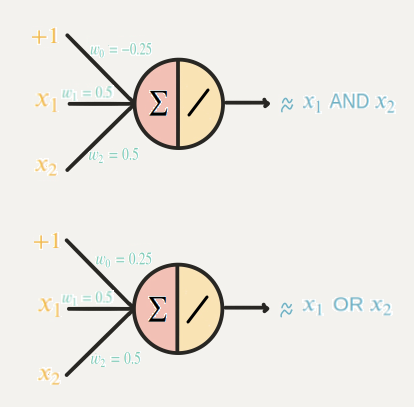

In [14]:
import tensorflow as tf

# OR gate model
or_linear_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,), dtype='float64'),
    tf.keras.layers.Dense(1, activation='linear')
])
or_linear_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
or_linear_model.summary()

# AND gate model
and_linear_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,), dtype='float64'),
    tf.keras.layers.Dense(1, activation='linear')
])
and_linear_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
and_linear_model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


2021-08-14 00:32:33.859199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-14 00:32:33.859274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
or_linear_model.fit(X, or_y, epochs=1000, verbose=0)
and_linear_model.fit(X, and_y, epochs=1000, verbose=0)
print('done')

2021-08-14 00:32:34.115614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-14 00:32:34.115782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-14 00:32:34.210702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-14 00:32:40.771661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


done


/Users/ho/miniforge3/envs/hs/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


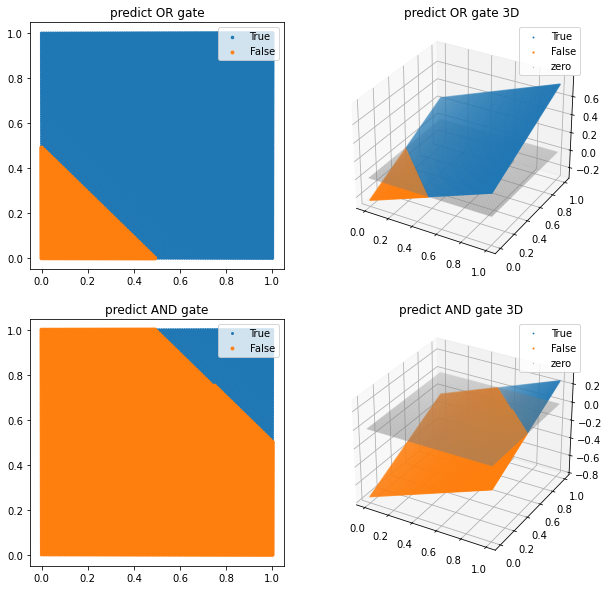

In [16]:
# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_or_y = or_linear_model(test_X)
pred_and_y = and_linear_model(test_X)

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ax1.set_title('predict OR gate')
ax1 = scatter_plot(ax1, test_X, pred_or_y, threshold=0.5)

ax2 = plt.subplot(2,2,2, projection='3d')
ax2.set_title('predict OR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_or_y, threshold=0.5, three_d=True)

ax3 = plt.subplot(2,2,3)
ax3.set_title('predict AND gate')
ax3 = scatter_plot(ax3, test_X, pred_and_y, threshold=0.5)

ax4 = plt.subplot(2,2,4, projection='3d')
ax4.set_title('predict AND gate 3D')
ax4 = scatter_plot(ax4, test_X, pred_and_y, threshold=0.5, three_d=True)

plt.show()

위의 예시를 보면 첫 번째 AND gate를 구현하기 위한 모델에 [[0,0],[0,1],[1,0],[1,1]]을 넣으면 나오는 출력값은 [[-0.25],[0.25],[0.25],[0.75]]이며, 두 번째 OR gate를 구현하기 위한 모델에 [[0,0],[0,1],[1,0],[1,1]]를 넣으면 출력값은 [[0.25],[0.75],[0.75],[1.25]]가 됩니다. 따라서 그림에도 결과가 유사하다는 표현을 해놓았습니다.  

하지만, 만약 0.50.5를 기준으로 기준보다 높으면 11이고 낮으면 0을 출력하게 한다면, 이 모델들은 AND gate와 OR gate를 완벽히 구현한다고 말할 수 있습니다.

그럼 이 모델로 **XOR gate**를 구현할 수 있을까요? 정답은 **'불가능하다'** 입니다.

2021-08-14 00:32:48.205496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


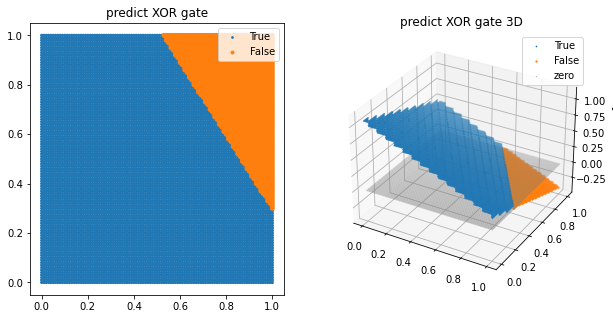

In [17]:
# XOR gate
xor_linear_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,), dtype='float64'),
    tf.keras.layers.Dense(1, activation='linear')
])
xor_linear_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
xor_linear_model.fit(X, xor_y, epochs=1000, verbose=0)

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_xor_y = xor_linear_model(test_X)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('predict XOR gate')
ax1 = scatter_plot(ax1, test_X, pred_xor_y, threshold=0.5)

ax2 = plt.subplot(1,2,2, projection='3d')
ax2.set_title('predict XOR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_xor_y, threshold=0.5, three_d=True)

plt.show()

### 선형 활성화 함수의 한계
여러 층을 쌓아도 불가능합니다.  

위에서도 다루었듯이 선형 활성화 함수를 사용하면 아무리 층을 쌓아도 결국 하나의 노드를 쓰는 것과 같습니다.  

비선형적 특성을 지닌 데이터를 예측하지 못 한다는 것이 한계입니다. 

## 비선형 활성화 함수
### 시그모이드, Softmax
#### 시그모이드 / 로지스틱
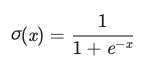

시그모이드 함수의 치역은 (0,1), 즉, 0 < σ(x) < 1 입니다.  

시그모이드 함수를 쓰는 가장 주된 이유가 바로 치역이 00과 11사이라는 것입니다. 특히 확률을 예측해야하는 모델에서 자주 사용됩니다.

시그모이드 함수의 미분은 다음과 같습니다.  
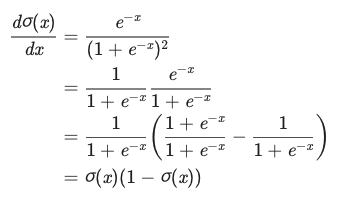

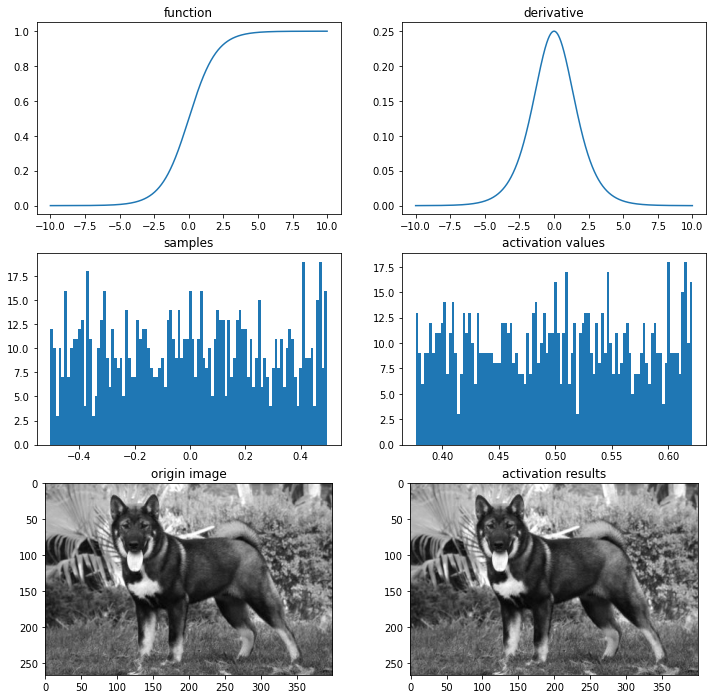

In [18]:
import os
img_path = os.getenv('HOME')+'/desktop/data/activation/jindo_dog.jpg'

# 시그모이드 함수
def sigmoid(x):
    return 1/(1+np.exp(-x).astype(np.float64))

def dev_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

# 시각화
ax = plot_and_visulize(img_path, sigmoid, dev_sigmoid)
ax.show()

### 수치 미분과 해석 미분의 차이

프로그램을 이용해서는 해석 미분을 구할 수 없기 때문에 꽤 많은 분들이 모르는 함수의 미분을 구할 때 수치 미분(numerical differentiation) 을 구합니다.  

어떤 함수 f(x)의 미분은 다음과 같이 표현할 수 있습니다.
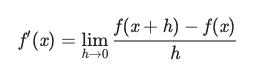



여기서 수치 미분이라고 하면 h의 값을 최대한 0에 가까운 값으로 잡아서 실제 미분값에 근사하게 만들어주는 것이라고 할 수 있습니다.
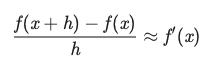

h의 값을 0에 가까운 아주 작은 수로 잡으면 수치 미분을 통해 계산한 값과 실제 미분을 통해 계산한 값은 차이가 없을 것으로 생각됩니다. 하지만 적당한 h를 주지 않는다면 생각보다 큰 차이가 있을 수 있습니다.

- (아주 작은 h를 주려고 h=1e-20이라고 선언한다면, 컴퓨터가 이를 그냥 0으로 인식해 x + h = x라는 결과를 출력해버립니다.)

이는 직접 그래프를 그려보는 것으로 확인할 수 있습니다.

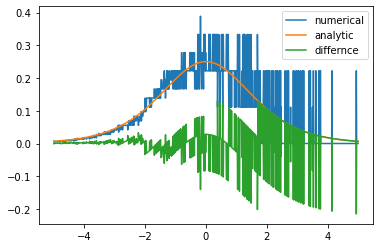

In [19]:
# 수치 미분
def num_derivative(x, function):
    h = 1e-15 # 이 값을 바꾸어 가며 그래프를 확인해 보세요
    numerator = function(x+h)-function(x)
    return numerator/h

# 두 그래프의 차이
diff_X = [-5+x/100 for x in range(1001)]
dev_y = np.array([dev_sigmoid(x) for x in diff_X])
num_dev_y = np.array([num_derivative(x, sigmoid) for x in diff_X])

diff_y = dev_y - num_dev_y
plt.plot(diff_X, num_dev_y, label='numerical')
plt.plot(diff_X, dev_y, label='analytic')
plt.plot(diff_X, diff_y, label='differnce')
plt.legend()

plt.show()

### 시그모이드 함수의 단점
시그모이드 함수는 0 또는 1에서 **포화(saturate)** 됩니다.  

역전파에서 이 0과 가까워진 그래디언트는 앞에서 온 역전파 값에 곱해지게 되는데 그렇게 되면 그 이후로 전파되는 모든 역전파 값이 0에 근접하게 되어 사실상 가중치 업데이트가 일어나지 않게 됩니다.  
이것을 **'그래디언트를 죽인다(kill the gradient)'** 라고 표현합니다.  

시그모이드 함수의 출력은 **0이 중심(zero-centered)이 아닙니다.** 여기서 발생하는 문제는 **훈련의 시간이 오래걸리게 된다는 것**입니다.  
만약 입력값으로 들어오는 데이터의 값이 모두 양수라고 가정하고 모델에 있는 어떤 한 노드의 출력값이 σ(∑i wi xi +b)라고 하겠습니다. 그럼 이 노드의 가중치 업데이트를 위해 구해야 하는 그래디언트는 다음과 같습니다.
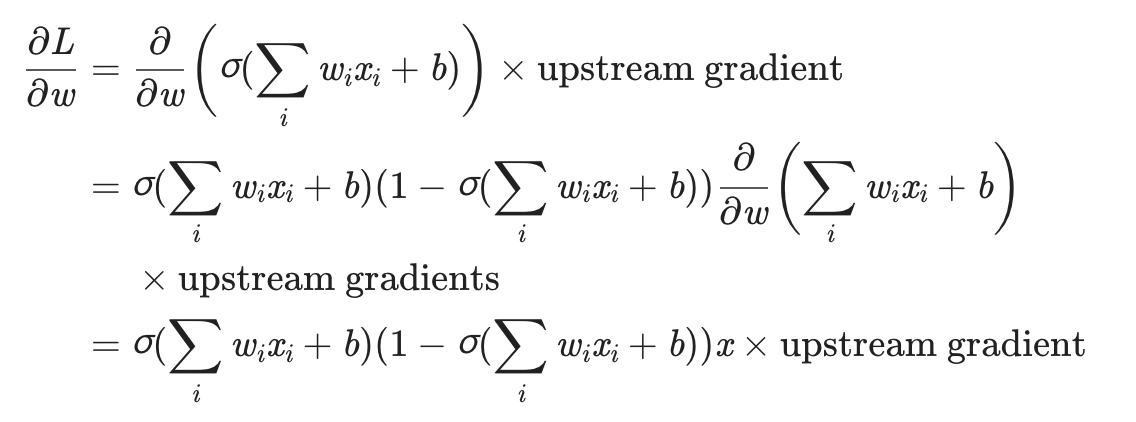

부호는 upstream gradient가 결정하게 됩니다.  
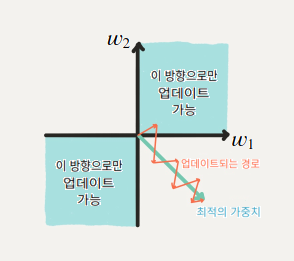
이런 식으로 업데이트가 이루어지면 최적값을 향해 직선적으로 업데이트되는 것보다 훨씬 시간이 오래걸리게 됩니다.  
이러한 단점들 때문에 최근에는 자주 사용하지 않게 되었습니다.


2021-08-14 00:32:55.641536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-14 00:33:02.522559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-14 00:33:09.353798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


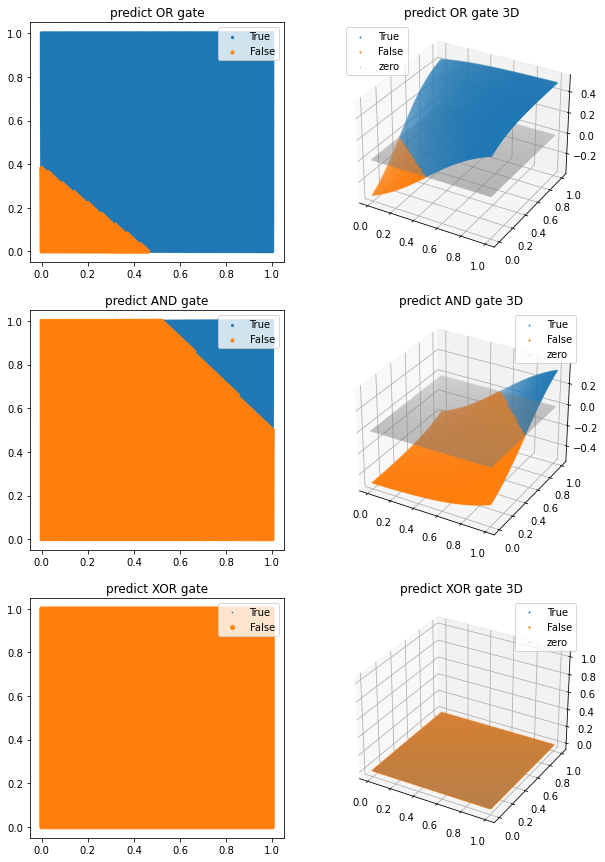

In [20]:
# OR gate
or_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
or_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
or_sigmoid_model.fit(X, or_y, epochs=1000, verbose=0)

# AND gate
and_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
and_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
and_sigmoid_model.fit(X, and_y, epochs=1000, verbose=0)

# XOR gate
xor_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
xor_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
xor_sigmoid_model.fit(X, xor_y, epochs=1000, verbose=0)

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_or_y = or_sigmoid_model(test_X)
pred_and_y = and_sigmoid_model(test_X)
pred_xor_y = xor_sigmoid_model(test_X)

plt.figure(figsize=(10,15))
ax1 = plt.subplot(3,2,1)
ax1.set_title('predict OR gate')
ax1 = scatter_plot(ax1, test_X, pred_or_y, threshold=0.5)

ax2 = plt.subplot(3,2,2, projection='3d')
ax2.set_title('predict OR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_or_y, threshold=0.5, three_d=True)

ax3 = plt.subplot(3,2,3)
ax3.set_title('predict AND gate')
ax3 = scatter_plot(ax3, test_X, pred_and_y, threshold=0.5)

ax4 = plt.subplot(3,2,4, projection='3d')
ax4.set_title('predict AND gate 3D')
ax4 = scatter_plot(ax4, test_X, pred_and_y, threshold=0.5, three_d=True)

ax5 = plt.subplot(3,2,5)
ax5.set_title('predict XOR gate')
ax5 = scatter_plot(ax5, test_X, pred_xor_y, threshold=0.5)

ax6 = plt.subplot(3,2,6, projection='3d')
ax6.set_title('predict XOR gate 3D')
ax6 = scatter_plot(ax6, test_X, pred_xor_y, threshold=0.5, three_d=True)

plt.show()

XOR gate를 구현하려면 좀 더 특수한 비선형 함수가 필요합니다.  
https://medium.com/@lucaspereira0612/solving-xor-with-a-single-perceptron-34539f395182  

2차 다항식(quadratic polynomial)을 추가한 시그모이드 함수를 사용한다면 XOR gate를 구현할 수 있습니다.

2021-08-14 00:33:17.945912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


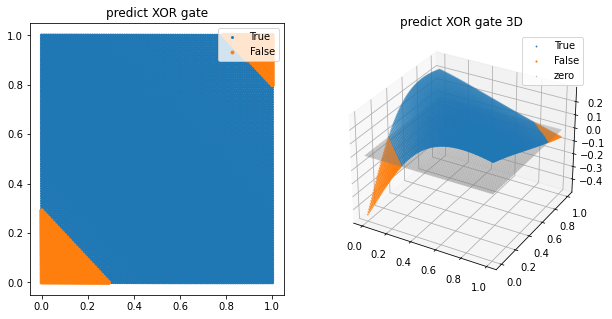

In [21]:
# 레이어를 추가했을 때
# XOR gate
xor_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(2, activation='sigmoid'), # 2 nodes로 변경
    tf.keras.layers.Dense(1)
])
xor_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
xor_sigmoid_model.fit(X, xor_y, epochs=1000, verbose=0)

plt.figure(figsize=(10,5))
pred_xor_y = xor_sigmoid_model(test_X)

ax1 = plt.subplot(1,2,1)
ax1.set_title('predict XOR gate')
ax1 = scatter_plot(ax1, test_X, pred_xor_y, threshold=0.5)

ax2 = plt.subplot(1,2,2, projection='3d')
ax2.set_title('predict XOR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_xor_y, threshold=0.5, three_d=True)

plt.show()

#### Softmax
시그모이드는 Binary Classification, 즉 참(11) or 거짓(00) 등 2가지 class를 분류할 때 많이 쓰입니다.  왜냐하면 시그모이드는 00 과 11 사이의 출력값을 가지고 있기 때문이죠.  

한편, Softmax는 10가지, 100가지 class 등 class의 수에 제한 없이 "각 class의 확률"을 구할 때 쓰입니다.  
가위, 바위, 보 사진 분류 문제는 3개 class 분류 문제이고, softmax는 각 class의 확률값, 즉 (0.2,0.5,0.3) 이렇게 출력값을 줍니다.  
Softmax의 가장 큰 특징은, 확률의 성질인 모든 경우의 수(=모든 class)의 확률을 더하면 1이 되는 성질을 가지고 있습니다.  
그래서 Softmax는 모델의 마지막 layer에서 활용이 됩니다.

### 하이퍼볼릭 탄젠트
하이퍼볼릭 탄젠트(tanh, Hyperbolic tangent) 함수는 쌍곡선 함수 중 하나입니다.  
https://ko.wikipedia.org/wiki/%EC%8C%8D%EA%B3%A1%EC%84%A0_%ED%95%A8%EC%88%98  
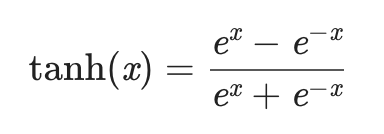

시그모이드 함수의 치역은 (−1,1), 즉, −1 < σ(x) < 1 입니다.  
그래프를 보면 알 수 있듯이 시그모이드 함수가 0이 중심이 아니었던 것과 다르게 하이퍼볼릭 탄젠트 함수는 0을 중심으로 하고 싶습니다.  
따라서 일반적으로 하이퍼볼릭 탄젠트 함수를 사용한 모델이 시그모이드 함수를 사용한 모델보다 더 빨리 훈련됩니다.
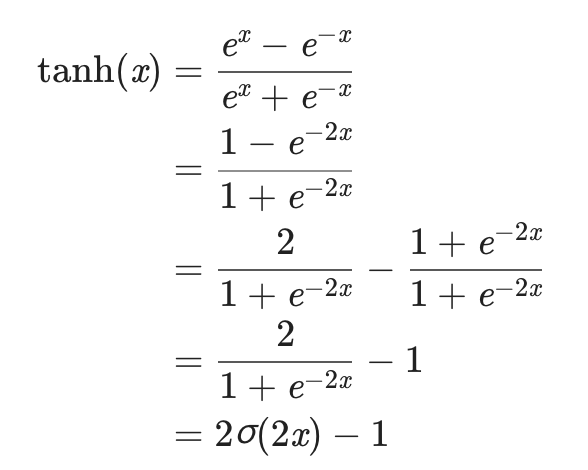

미분은 다음과 같습니다. 
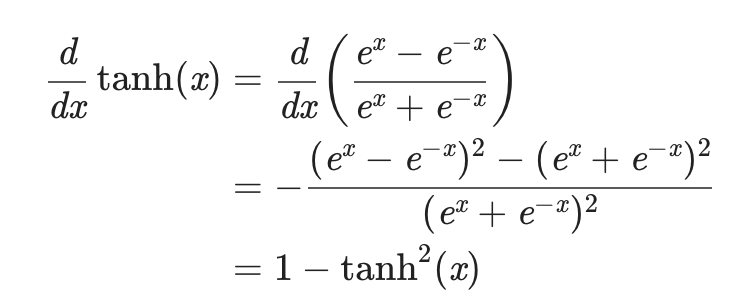

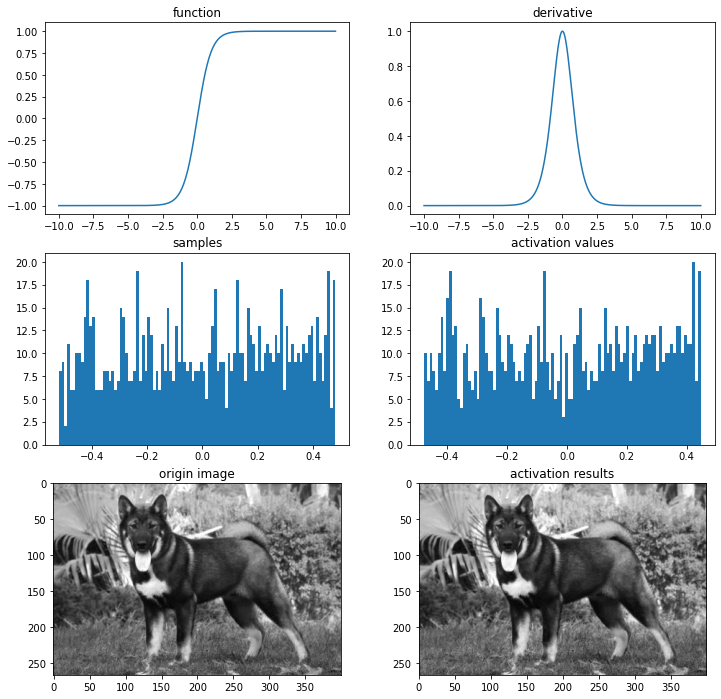

In [22]:
import os
img_path = os.getenv('HOME')+'/desktop/data/activation/jindo_dog.jpg'

# 하이퍼볼릭 탄젠트 함수
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def dev_tanh(x):
    return 1-tanh(x)**2

# 시각화
ax = plot_and_visulize(img_path, tanh, dev_tanh)
ax.show()

#### 하이퍼볼릭 탄젠트 함수의 단점
-1 또는 1에서 포화됩니다.

### ReLU
ReLU(rectified linear unit) 함수는 최근 가장 많이 사용되고 있는 활성화 함수입니다. ReLU의 식은 다음과 같습니다.
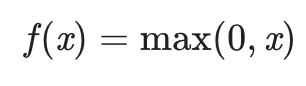

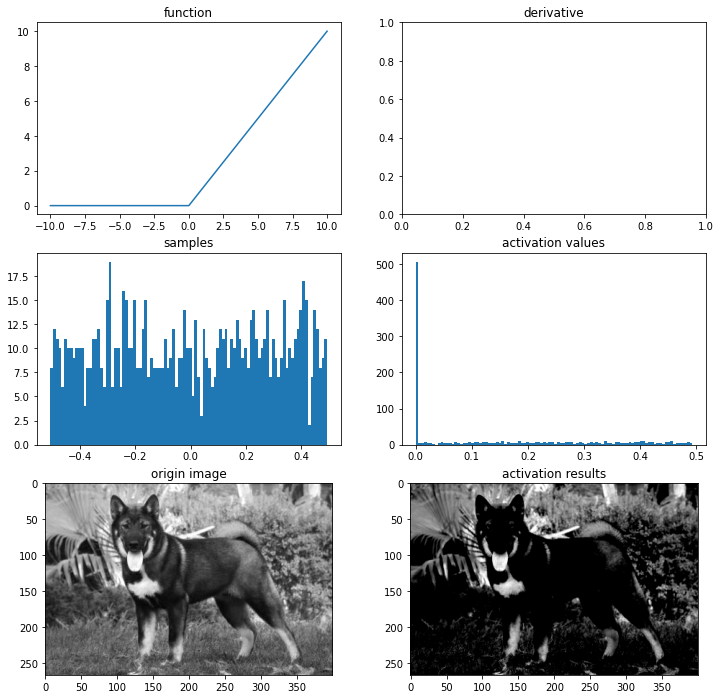

In [23]:
import os
img_path = os.getenv('HOME')+'/desktop/data/activation/jindo_dog.jpg'

# relu 함수
def relu(x):
    return max(0,x)

# 시각화
ax = plot_and_visulize(img_path, relu)
ax.show()

ReLU함수의 치역은 (0,∞)입니다.  
ReLU를 사용한 모델은 하이퍼볼릭 탄젠트를 사용한 모델보다 몇 배 더 빠르게 훈련이 됩니다.  

이는 아래의 그래프를 통해서 확인할 수 있습니다.
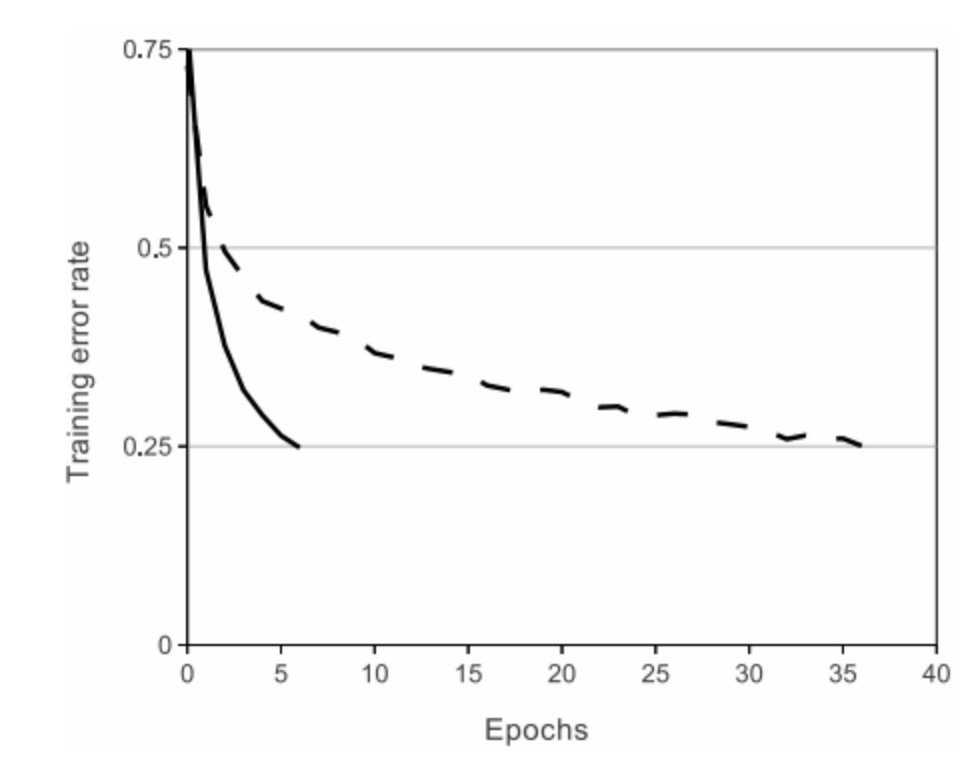
위 그래프는 에포크당 훈련 에러 비율을 나타내고 있습니다.  
실선이 ReLU 함수를 사용한 모델의 에러 비율이고, 점선이 하이퍼볼릭 탄젠트 함수를 사용한 모델의 에러 비율입니다.  
또한 ReLU 함수는 시그모이드나 하이퍼볼릭 탄젠트처럼 비용이 높은 (예를 들면, exponential와 같은) 연산을 사용하지 않기 때문에 처리 속도가 빠릅니다.

ReLU는 0을 제외한 구간에서 미분이 가능합니다.  
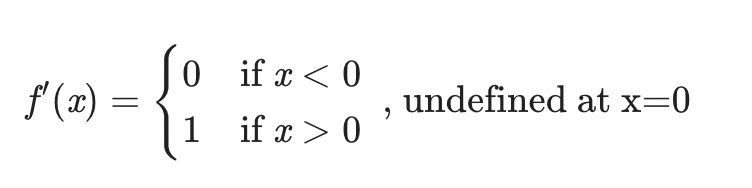


왜 x=0 에서는 미분이 안 된다고 하는 걸까요? 
먼저, 어떤 함수 f가 있을 때 우미분(right-hand derivative)와 좌미분(left-hand derivative)은 다음과 같이 정의됩니다.

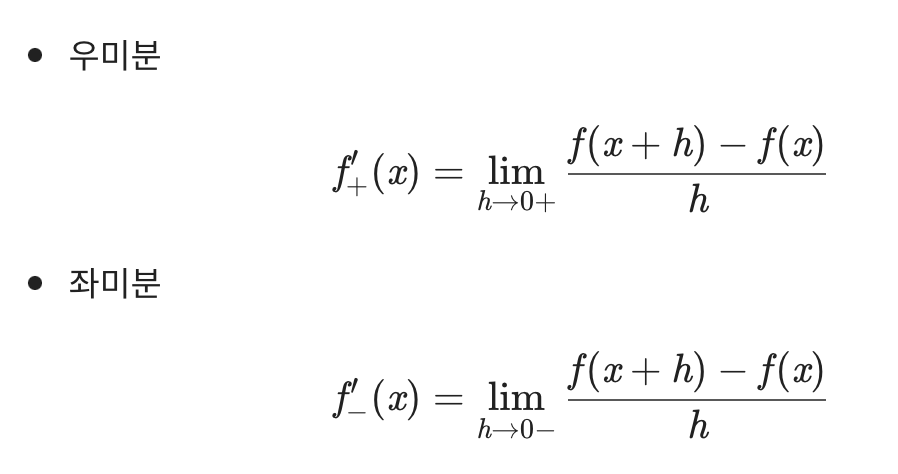

이때, 어떤 값 x=a에 대해 함수 f의 미분이 존재한다는 것은 그 값에 대한 함수의 우미분과 좌미분값이 같다는 것입니다. 

수식으로 표현하면 다음과 같습니다.
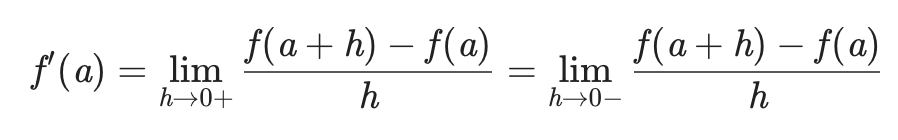

따라서 만약 어떤 값에 대해 함수의 좌미분 값과 우미분 값이 다르다면, 그 함수는 그 값에 대해 미분이 불가능하다고 표현할 수 있습니다.  

그럼 x=0일 때 ReLU 함수의 우미분과 좌미분을 구해보면 다음과 같습니다.
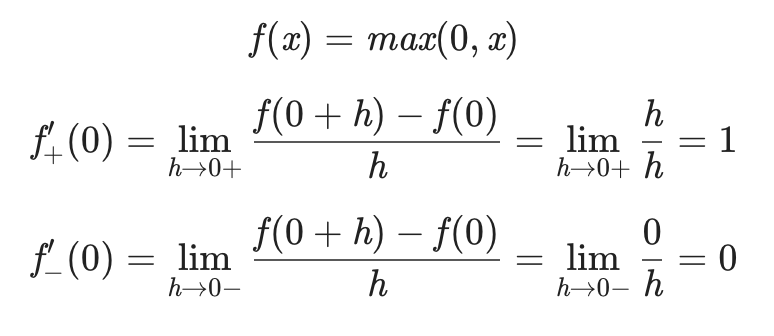
즉, x=0일 때 ReLU 함수의 우미분과 좌미분이 다르므로, ReLU함수는 x=0에서 미분이 불가능합니다.  

그렇다면 만약 실제 문제를 풀 때 ReLU 함수의 그래디언트를 구하는 과정에서 0값이 주어지면 어떻게 처리될까요?  
그러한 상황에선 일반적으로 무작위하게 0 또는 1을 출력합니다.



#### ReLU 함수를 이용한 모델은 비선형적 데이터의 특징을 잘 잡아낼까?

'시그모이드 함수처럼 곡선이 포함되어있지 않은데 어떻게 비선형적 데이터의 특징을 잡아낼까?'  

ReLU 함수로도 f(x) = x^2와 같은 함수를 표현할 수 있습니다.  
어려운 참고 자료: https://arxiv.org/abs/1807.03973

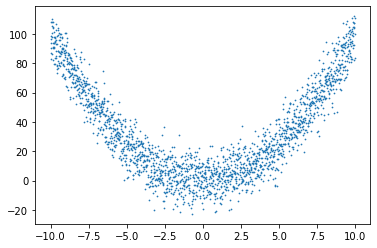

In [24]:
q_X = np.array([-10+x/100 for x in range(2001)])
q_y = np.array([(x)**2 + np.random.randn(1)*10 for x in q_X])
plt.scatter(q_X, q_y, s=0.5)

In [25]:
approx_relu_model_p = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,)),
    tf.keras.layers.Dense(6, activation='relu'), # 6 nodes 병렬 연결
    tf.keras.layers.Dense(1)
])
approx_relu_model_p.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['accuracy'])
approx_relu_model_p.fit(q_X, q_y, batch_size=32, epochs=100, verbose=0)

approx_relu_model_s = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,)),
    tf.keras.layers.Dense(2, activation='relu'),# 2 nodes 직렬로 3번 연결
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1)
])
approx_relu_model_s.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['accuracy'])
approx_relu_model_s.fit(q_X, q_y, batch_size=32, epochs=100, verbose=0)

approx_relu_model_p.summary()
approx_relu_model_s.summary()

2021-08-14 00:33:27.086776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-14 00:33:58.274690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 6)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 6         
____________________________________

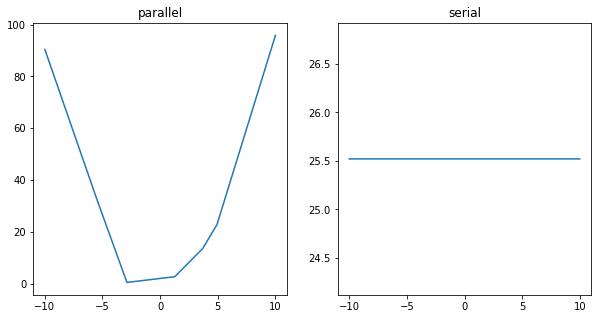

In [26]:
q_test_X = q_X.reshape((*q_X.shape,1))
plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
ax1.set_title('parallel')
pred_y_p = approx_relu_model_p(q_test_X)
ax1.plot(q_X, pred_y_p)

ax2 = plt.subplot(1,2,2)
ax2.set_title('serial')
pred_y_s = approx_relu_model_s(q_test_X)
ax2.plot(q_X, pred_y_s)

plt.show()

실제로 x^2의 그래프를 근사할 수 있는지 확인해봄과 동시에 노드를 병렬로 쌓는 것과 직렬로 쌓는 것 중에 어느 것이 더 좋은지도 비교해 보았습니다. 

이 결과로 우리는 ReLU함수를 사용해도 충분히 x^2와 같은 비선형적 데이터를 예측해낼 수 있다는 것을 알 수 있었고, 파라미터 수가 같음에도 불구하고 노드를 병렬로 쌓은 것이 직렬로 쌓은 것보다 더 좋은 결과를 낸 것을 확인할 수 있었습니다.

#### ReLU 함수의 단점
ReLU 함수의 출력값이 0의 중심이 아닙니다.  
또 다른 단점은 **Dying ReLU**입니다.  
이것의 의미는 모델에서 ReLU를 사용한 노드가 비활성화되며 출력을 0으로만 하게 되는 것입니다.  

왜 이런 상황이 발생하는지 알아보겠습니다. 
어떤 모델에 있는 한 노드의 출력값이 max(o,∑i wi xi + b)라고 하겠습니다. 그럼 이 노드의 가중치 업데이트를 위해 구해야 하는 그래디언트는 다음과 같습니다. 
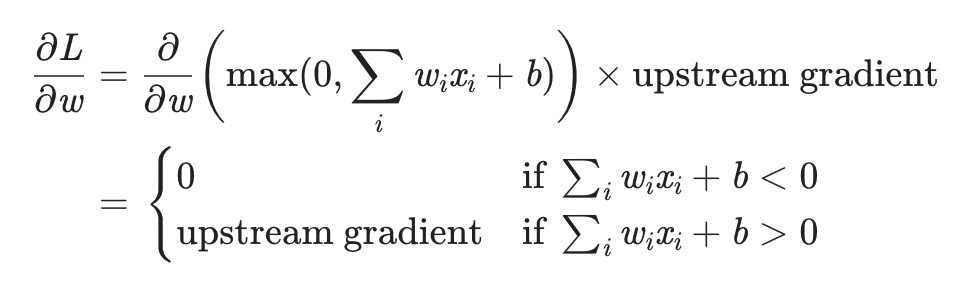

만약, 이전 훈련 스텝에서 이 노드의 가중치가 업데이트되어 ∑i wi xi + b가 가중지 w값에 의해 입력값 x에 상관없이 0 이하로 나오게 되었다면, 이 이후의 업데이트에서는 그래디언트가 항상 0이 되어 가중치 업데이트가 일어나지 않게 됩니다.  
즉, 이 노드의 출력값과 그래디언트가 0이 되어 **노드가 죽어**버립니다.  

이러한 문제는 특히 학습률(learning rate)을 크게 잡을 때 자주 발생합니다.  
반대로 학습률을 줄여준다면 이 문제는 적게 발생합니다.

### ReLU의 단점을 극복하기 위한 시도들
#### Leaky ReLU
Leaky ReLU함수는 ReLU 함수의 'Dying ReLU'를 해결하기 위한 시도 중 하나입니다. 식을 먼저 보겠습니다.
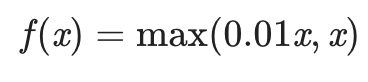

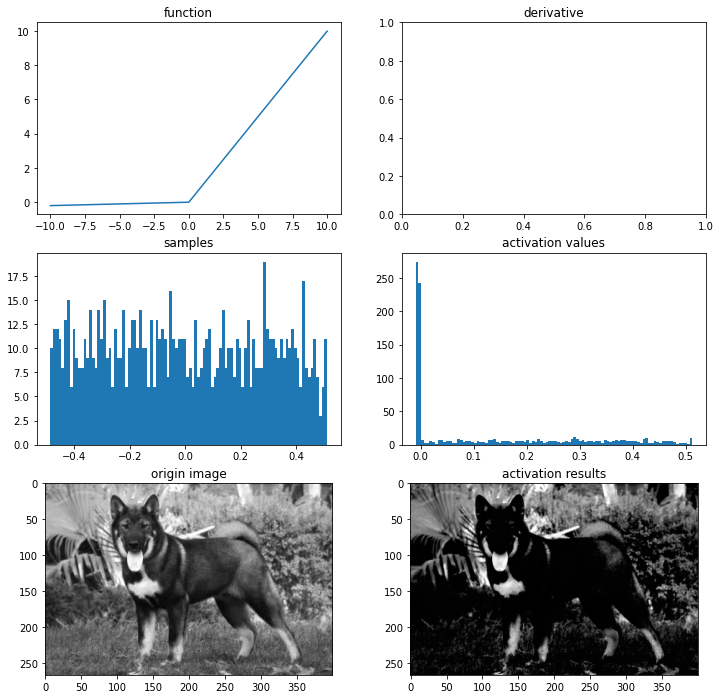

In [27]:
import os
img_path = os.getenv('HOME')+'/desktop/data/activation/jindo_dog.jpg'

# leaky relu 함수
def leaky_relu(x):
    return max(0.02*x,x)

# 시각화
ax = plot_and_visulize(img_path, leaky_relu)
ax.show()

'Dying ReLU'를 발생시켰던 0을 출력하던 부분을 아주 작은 음수값을 출력하게 만들어 주어 해당 문제를 해결하였습니다.

이 부분을 제외하고는 ReLU와 같은 특성을 가집니다.

#### PReLU
PReLU(parametric ReLU) 는 Leaky ReLU와 유사하지만 새로운 파라미터를 추가하여 0 미만일 때의 '기울기'가 훈련되게 했습니다. 식으로 표현하면 다음과 같습니다.
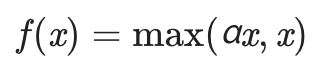

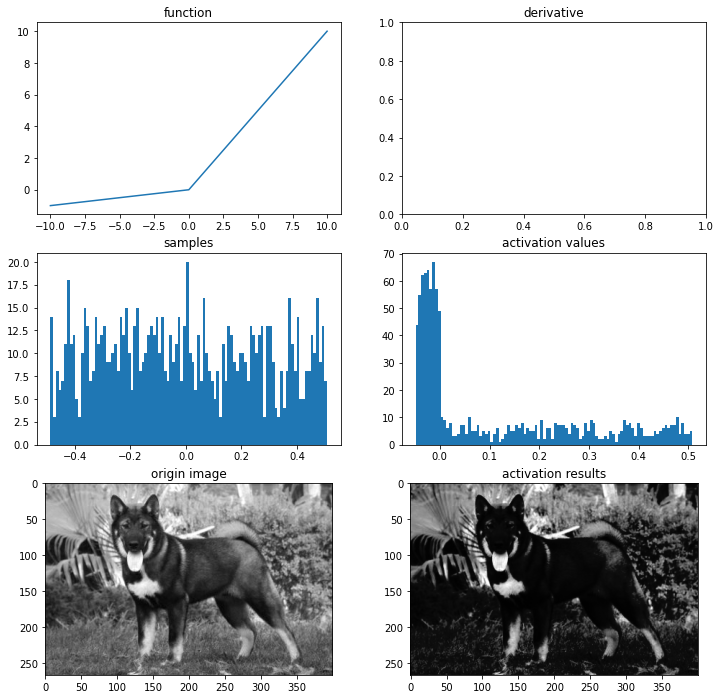

In [28]:
# PReLU 함수
def prelu(x, alpha):
    return max(alpha*x,x)

# 시각화
ax = plot_and_visulize(img_path, lambda x: prelu(x, 0.1)) # parameter alpha=0.1일 때

ax.show()

#### ELU
ELU(exponential linear unit)은 ReLU의 모든 장점을 포함하며, 0이 중심점이 아니었던 단점과, 'Dying ReLU'문제를 해결한 활성화 함수입니다. 식은 다음과 같습니다.
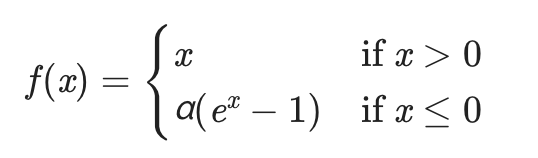

ELU의 미분은 논문에서 다음과 같이 정의하고 있습니다.
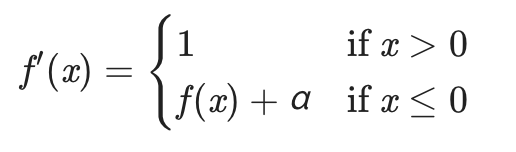

이 함수의 단점은 exponential 연산이 들어가서 계산 비용이 높아졌다는 점이 있습니다.

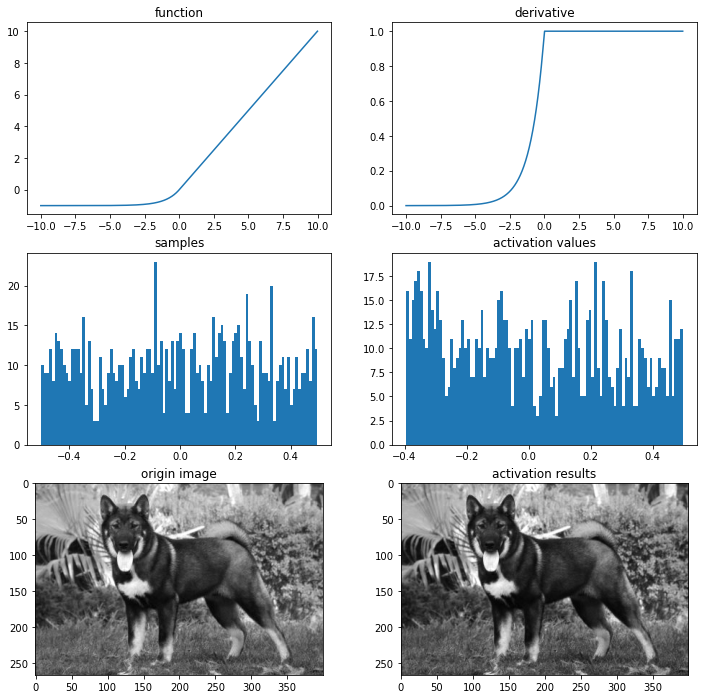

In [29]:
# leaky relu 함수
def elu(x, alpha):
    return x if x > 0 else alpha*(np.exp(x)-1)

def dev_elu(x, alpha):
    return 1 if x > 0 else elu(x, alpha) + alpha

# 시각화
ax = plot_and_visulize(img_path, lambda x: elu(x, 1), lambda x: dev_elu(x, 1)) # alpha가 1일 때
ax.show()

이 밖의 여러 활성화 함수들 : 위키피디아 - Activation function  
https://en.wikipedia.org/wiki/Activation_function

https://www.youtube.com/watch?v=1Du1XScHCww&ab_channel=SefikIlkinSerengil